In [ ]:
#eBCH(16,7)の凍結ビット制約行列
V = [
    0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
    0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0
    0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
    0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 
    0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
    0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 
    0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
]
#16ビットの01の系列を作成, Vector{Int}を'で転置する
u = rand(0:1,16)'

#uはベクトルなので、ベタ書きでもかける
#u = [0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0]

#F2上の演算なので法が2のmodを取る
mod.(u * V',2)

1×9 Matrix{Int64}:
 1  0  1  0  1  0  1  1  1

In [15]:
include("../solver/BPsolver.jl")
function bitflip_for_dynamic_eBCH_16_7_6(i,t::BPProblem)
    t.R[4,1] = (1-2*(i%2))*floatmax()
    t.R[6,1] = (1-2*(i>>1%2))*floatmax()
    t.R[7,1] = t.R[4,1]
    t.R[10,1] = t.R[6,1]
    t.R[11,1] = sign(t.R[4,1])sign(t.R[6,1])floatmax()
    t.R[13,1] = t.R[11,1]
end
F = [1,2,3,5,9];
_t = BPProblem(16,7,100)
bitflip_for_dynamic_eBCH_16_7_6(1,_t)
_t.R

16×5 Matrix{Float64}:
  0.0          0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
 -1.79769e308  0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
  1.79769e308  0.0  0.0  0.0  0.0
 -1.79769e308  0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
 -1.79769e308  0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
 -1.79769e308  0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0
  0.0          0.0  0.0  0.0  0.0

In [14]:
include("../solver/BPsolver.jl")

function errors(t::BPProblem)
    sum(ifelse(t.L[i,end]+t.R[i,end] > 0,0,1) for i=1:t.N)
end

function hamming_distance(t::BPProblem)
    sum(ifelse(sign(t.L[i,end]+t.R[i,end])!=sign(t.L[i,end]),1,0) for i=1:t.N)
end

#polar符号 通常の構成法では4,6は凍結ビットなので、失敗しそう？
function bitflip_for_dynamic_eBCH_16_7_6(i,t::BPProblem)
    t.R[4,1] = (1-2*(i%2))*floatmax()
    t.R[6,1] = (1-2*(i>>1%2))*floatmax()
    t.R[7,1] = t.R[4,1]
    t.R[10,1] = t.R[6,1]
    t.R[11,1] = sign(t.R[4,1])sign(t.R[6,1])floatmax()
    t.R[13,1] = t.R[11,1]
end

function BP(
    N,mi,
    L,R,M,
    checkcond)

    n = Int(log2(N))

    for iter=1:mi
        @views for m=1:n
            j = n-m+1
            @simd for i in M[:,j]
                R[i,m+1] = f(R[i,m],L[i+N>>j,m+1]+R[i+N>>j,m])
                R[i+N>>j,m+1] = R[i+N>>j,m]+f(R[i,m],L[i,m+1])
            end
        end
        
        @views for m=n:-1:1
            j = n-m+1
            @simd for i in M[:,j]
                L[i,m] = f(L[i,m+1],L[i+N>>j,m+1]+R[i+N>>j,m])
                L[i+N>>j,m] = L[i+N>>j,m+1]+f(L[i,m+1],R[i,m])
            end
        end

        if checkcond()
            return true,iter
        end
    end
    
    return false,mi
end

@inline function select_by_sum_absolute_LLR(t::BPProblem)
    sum(abs(t.L[i,1]) for i=1:t.N)
end

function Gmatrix(u,v,L,R)
    N = size(L)[1]
    for i=1:N
        v[i] = harddecision(Int,L[i,end],R[i,end])
        u[i] = harddecision(Int,L[i,1],R[i,1])
    end 
    Gcheck(u,v)
end

function reliability_value(llr,index)
    sum(abs,llr[index])
end

function solver(sim,t::BPProblem,ch::AWGN)
    n = Int(log2(t.N)); 
    u = zeros(Int,t.N); v = zeros(Int,t.N)
    checkcond() = Gmatrix(u,v,t.L,t.R)

    F = [1,2,3,5,9]
    bler = 0; ber = 0; 
    List = [false,false,false,false]
    hammingdistance = [0,0,0,0]
    error = [0,0,0,0]
    absolute_llr = zeros(4)

    correct_absolute_llr = Float64[]
    error_absolute_llr = Float64[]

    k = rand(1:sim)

    bp_iter_arr = zeros(Int,4)

    not_in_list = 0
    reliability_arr = zeros(4)

    error_dist = Int[]
    bp_iter_mean = Int[]
    for iter=1:sim
        initialize!(t.L,t.R,F,ch)
        bp_iter = t.mi
        for i=0:3
            initializeLandR!(t.L,t.R,F,ch.llr)
            bitflip_for_dynamic_eBCH_16_7_6(i,t)
            List[i+1],bp_iter = BP(t.N,t.mi,t.L,t.R,t.M,checkcond)
            hammingdistance[i+1] = hamming_distance(t)
            absolute_llr[i+1] = select_by_sum_absolute_LLR(t)
            if !List[i+1]; hammingdistance[i+1] = t.N+1; end
            bp_iter_arr[i+1] = bp_iter
            if !List[i+1]; bp_iter_arr[i+1] = t.mi; end

            if List[i+1]
                index = Int[]
                for j=1:t.N
                    if sign(t.L[j,end] + t.R[j,end]) != sign(ch.llr[j])
                        push!(index,j)
                    end
                end
                reliability_arr[i+1] = reliability_value(ch.llr,index)
            else
                reliability_arr[i+1] = floatmax()
            end
            error[i+1] = errors(t)
        end
        #if isnothing(findfirst(isequal(true),List)); println("error"); end
        #open("result.txt",iter == 1 ? "w" : "a") do file
        #    println(file,reliability_arr)
        #end
        #selected = findfirst(isequal(minimum(hammingdistance)),hammingdistance)
        #selected = findfirst(isequal(maximum(absolute_llr)),absolute_llr)
        selected = 0
        bp_iter_select = findall(isequal(minimum(bp_iter_arr)),bp_iter_arr)
        push!(bp_iter_mean,minimum(bp_iter_arr))
        #=
        if length(bp_iter_select) > 1
            bp_iter_select = findall(isequal(minimum(hammingdistance[bp_iter_select])),hammingdistance[bp_iter_select])
            if length(bp_iter_select) > 1; println("error",hammingdistance); end
        end
        =#
        # random に選ぶ　苦肉の策だ（笑）
        #selected = rand(bp_iter_select)

        selected = findfirst(isequal(minimum(reliability_arr[bp_iter_select])),reliability_arr)
        #if !in(1,bp_iter_select); not_in_list += 1; println(bp_iter_select); end

        if isnothing(findfirst(isequal(true),List))
            bler += 1
        else 
            bler += ifelse(error[selected]!=0,1,0)
        end
        #bler += ifelse(error[selected]!=0,1,0)
        if !iszero(error[selected])
            push!(error_absolute_llr,absolute_llr[selected])
        else
            push!(correct_absolute_llr,absolute_llr[selected])
        end
              
        ber += error[selected]

        push!(error_dist,error[selected])

    end
    open("bp_iter_mean$(ch.eb).txt","a") do file
        println(file,bp_iter_mean)
    end

    return bler/sim,ber/(sim*t.N),error_dist,bp_iter_mean
end

p(;N,K,eb,sim) = begin
    a = AWGN(N,K,8,eb)
    t = BPProblem(N,K,10)
    res = solver(sim,t,a)
    res
end

p (generic function with 1 method)

In [15]:
res = p(N=16,K=7,eb=3.0,sim=10000)

(0.0316, 0.01186875, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3, 2, 2, 1, 2, 3, 1, 2, 2  …  2, 2, 2, 2, 2, 2, 1, 2, 1, 2])

10
1.8656


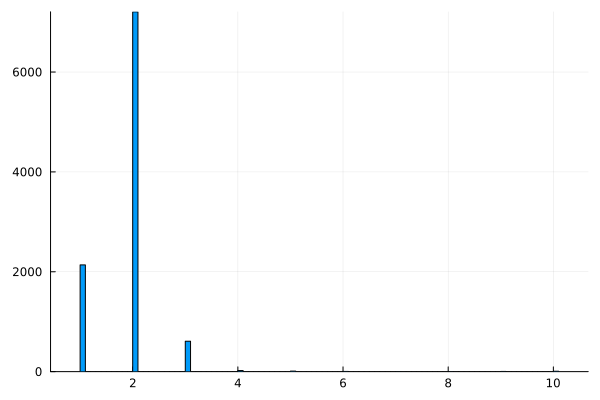

In [ ]:
using StatsPlots
using Plots
println(maximum(res[4]))
println(sum(res[4])/10000)
boxplot(res[4],label="")
histogram(res[4],label="")

In [12]:
res = p(N=16,K=7,eb=6.0,sim=100000)

(0.00029, 0.00011, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
using StatsPlots
boxplot(filter(!iszero,res[3]),label="")
using Plots
histogram(filter(!iszero,res[3]),label="")
println(length(filter(!iszero,res[3])))
6*29/100000/16

29


0.00010875

In [30]:
p(N=16,K=7,eb=5.0,sim=100000)

(0.00207, 0.00078, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
p(N=16,K=7,eb=3.0,sim=100000)

(0.02992, 0.011596875, [112.58169484518523, 204.68350711137268, 173.37254774476062, 101.30094338364422, 95.70389979449614, 133.18236908108028, 143.22214383591185, 74.86266672446166, 111.81668715746129, 151.620732149029  …  136.6835953029053, 165.7655977576225, 94.98692845253743, 158.40791352499207, 161.40707542823904, 85.91904981381543, 167.4673227343295, 149.063096240325, 166.92640984043106, 159.02461833578997], [46.28131051640281, 67.65841252949512, 34.07097327928199, 31.0412708536158, 67.19320319128987, 76.58757413952283, 42.358063275193444, 39.17049999673512, 82.65090773869855, 42.90997020943444  …  76.05595770656642, 52.6300275914925, 101.16508562530717, 23.221797846807174, 57.161044561185676, 54.93600442317226, 82.14900324585277, 64.54790523878943, 84.32250537633112, 120.53784304310722])

In [16]:
p(N=16,K=7,eb=6.0,sim=100000)

(0.00029, 0.00011125, [285.62160391385885, 290.7743496522478, 365.75863280305094, 118.04540884080542, 205.7088055297483, 146.16997165219425, 224.6159695091391, 176.26978134209122, 118.64279639444379, 165.5530870797616  …  222.83944537849868, 165.29545383577445, 112.26868449284125, 153.6044326653045, 366.6726079377624, 191.8873375635355, 157.85203133876374, 339.72137149621636, 164.63333609774057, 358.92699592934616], [75.48158669528272, 108.96605733683131, 195.51144364860255, 66.88640647373161, 197.76998714213346, 119.55772643044807, 101.9004252299307, 127.0702701610779, 117.04790156422516, 61.595045214561715  …  118.05243272409288, 69.16703082051279, 122.69880944630718, 109.14988282245763, 126.88486632246659, 60.050738642737734, 110.6555601354111, 93.37422199777232, 95.38147492798488, 77.67228546079366])

In [12]:
p(N=16,K=7,eb=3.0,sim=1000000)

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


(0.029713, 0.0116100625, [112.58169484518523, 204.68350711137268, 173.37254774476062, 101.30094338364422, 95.70389979449614, 133.18236908108028, 143.22214383591185, 74.86266672446166, 111.81668715746129, 151.620732149029  …  159.16717220181812, 155.82765520754901, 93.59372906444581, 130.69191655770737, 74.72002036315865, 186.17774866267334, 92.20987863251673, 128.96520857342438, 104.47567215536367, 143.7691795919772], [46.28131051640281, 67.65841252949512, 34.07097327928199, 31.0412708536158, 67.19320319128987, 76.58757413952283, 42.358063275193444, 39.17049999673512, 82.65090773869855, 42.90997020943444  …  87.20321708528273, 66.4392793598315, 23.82413704836304, 72.23801648521454, 39.15513185430958, 90.02201774592557, 35.212341528512276, 64.58107080600847, 72.90308776145102, 56.131812327172824])

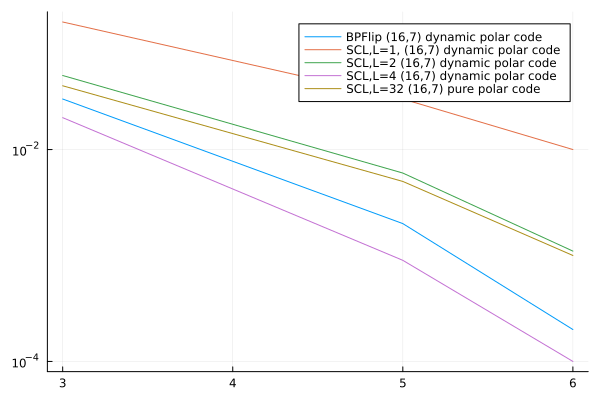

In [ ]:
using Plots
plot!([3.0,5.0,6.0],[0.04,0.005,0.001],yscale=:log10,label="SCL,L=32 (16,7) pure polar code")
plot([3.0,5.0,6.0],[0.03,0.002,0.0002],yscale=:log10,label="BPFlip (16,7) dynamic polar code")
plot!([3.0,5.0,6.0],[0.16,0.03,0.01],yscale=:log10,label="SCL,L=1, (16,7) dynamic polar code ")
plot!([3.0,5.0,6.0],[0.05,0.006,0.0011],yscale=:log10,label="SCL,L=2 (16,7) dynamic polar code ")
plot!([3.0,5.0,6.0],[0.02,0.0009,0.0001],yscale=:log10,label="SCL,L=4 (16,7) dynamic polar code ")
plot!([3.0,5.0,6.0],[0.04,0.005,0.001],yscale=:log10,label="SCL,L=32 (16,7) pure polar code")
#plot!([3.0,5.0,6.0],[0.02,0.0009,0.0001],yscale=:log10,label="SCL,L=32 (16,7) dynamic Polar Code ")
#おそらくMLなので、BPはこれを目指す


# Turbo復号にBPを適用する利点はあるのか？
- BERが低くやる意味がない気がしてきた

In [ ]:
L,L=32 (16,7)")
plot!([3.0,5.0,6.0],[0.02,0.0009,0.0001],yscale=:log10,label="SCL,L=4 (16,7) dynamic Polar Code ")
plot!([3.0,5.0,6.0],[0.16,0.03,0.01],yscale=:log10,label="SCL,L=1, (16,7) dynamic Polar Code ")
plot!([3.0,5.0,6.0],[0.05,0.006,0.0011],yscale=:log10,label="SCL,L=2 (16,7) dynamic Polar Code ")
#plot!([3.0,5.0,6.0],[0.02,0.0009,0.0001],yscale=:log10,label="SCL,L=32 (16,7) dynamic Polar Code ")
#おそらくML なので、BPはこれを目指す


In [10]:
p(N=16,K=7,eb=6.0,sim=100000)

error


(0.00029, 0.00011125, [285.62160391385885, 290.7743496522478, 365.75863280305094, 118.04540884080542, 205.7088055297483, 146.16997165219425, 224.6159695091391, 176.26978134209122, 118.64279639444379, 165.5530870797616  …  222.83944537849868, 165.29545383577445, 112.26868449284125, 153.6044326653045, 366.6726079377624, 191.8873375635355, 157.85203133876374, 339.72137149621636, 164.63333609774057, 358.92699592934616], [75.48158669528272, 108.96605733683131, 195.51144364860255, 66.88640647373161, 197.76998714213346, 119.55772643044807, 101.9004252299307, 127.0702701610779, 117.04790156422516, 61.595045214561715  …  118.05243272409288, 69.16703082051279, 122.69880944630718, 109.14988282245763, 126.88486632246659, 60.050738642737734, 110.6555601354111, 93.37422199777232, 95.38147492798488, 77.67228546079366])

In [3]:
p(N=16,K=7,eb=5.0,sim=100000)

(0.00207, 0.000801875, [213.56986324606544, 209.31328999514614, 285.8512670852301, 189.47296155365657, 159.93386821330077, 106.8698266645415, 156.80813550469566, 133.69631028830935, 215.59205531106528, 259.41560683122225  …  158.85244759618638, 276.5202464010528, 223.15176323284732, 267.764763313744, 281.41780361080714, 147.61547192202818, 283.40978943258676, 262.1237111878188, 123.32531754773994, 276.867281840229], [109.11231512924235, 132.63828172126986, 93.5183174576413, 71.80634783060636, 117.19825102655321, 97.52859025420409, 90.1919745699859, 50.16269466333548, 59.07330981748882, 82.87224134901842  …  26.690114536552073, 73.33831529524029, 133.75643936056778, 83.78833983577864, 93.74722689320069, 52.60642940502845, 71.36620626435635, 68.08098880433317, 87.56877152225356, 77.41790120340126])

In [58]:
p(N=16,K=7,eb=4.0,sim=10000)

[3]
[2, 4]
[3]
[3]
[3]
[2]
[4]
[2]
[2]
[4]
[4]
[4]
[3, 4]
[2]
[3]
[4]
[4]
[3]
[2]
[3]
[2]
[4]
[4]
[3]
[2]
[3]
[3]
[2, 3]
[3]
[2, 3]
[4]
[3]
[2]
[4]
[4]
[4]
[3]
[2, 4]
[4]
[3]
[2]
[4]
[2]
[3]
[2]
[4]
[3]
[3]
[4]
[4]
[2]
[3]
[3]
[3]
[4]
[3]
[4]
[2]
[4]
[2]
[4]
[4]
[4]
[3]
[2]
[3]
[2]
[3, 4]
[4]
[2]
[2]
71


(0.0405, 0.01516875, [156.5189895500708, 144.2028924487845, 223.5380471605857, 123.95051560947849, 76.65713879797875, 104.29883101161496, 100.5662674944914, 158.12746008266052, 198.9066564225311, 185.2722632714531  …  256.71418485520974, 85.12473904174942, 229.42226075534816, 152.09812752152925, 191.63769651620245, 146.2739729601042, 120.93010765795759, 188.4198145292673, 111.02938575826155, 200.332503099814], [30.52705323698482, 47.732085958639544, 110.60205250204402, 29.22046823564286, 35.74694175465343, 79.08310300966983, 53.59263862238688, 97.19188862706163, 124.96592264885163, 74.04494745774052  …  35.66479666722205, 40.77704505101748, 50.63875344984284, 48.86123250494468, 66.54172491989765, 65.4383948358093, 52.05824828884042, 79.35100185988072, 49.77470393296119, 65.11601354514228])

In [8]:
N = 16; K = 7; eb=3.0; sim = 10000
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

(0.0281, 0.01068125, [112.58169484518523, 204.68350711137268, 173.37254774476062, 101.30094338364422, 95.70389979449614, 133.18236908108028, 74.86266672446166, 111.81668715746129, 151.620732149029, 155.48349322132793  …  194.23488307581835, 139.9784480324053, 160.951402837781, 111.58065149420848, 142.51788862313944, 103.05172649744897, 93.01195837415654, 142.9632415073706, 84.18793069285111, 151.70720579079847], [69.9752057946863, 46.28131051640281, 18.950604108478238, 31.0412708536158, 67.19320319128987, 42.623976113278864, 83.51630852069897, 56.24540198824845, 66.59228144309282, 72.33438399355045  …  97.13792861390101, 57.276801158410024, 42.92484902130815, 72.1196127722283, 62.00731656196919, 52.80395502294199, 89.78846417638098, 40.14388209810461, 36.7013479095225, 61.724652171158866])

In [12]:
#バタチャリアで構成した場合の凍結ビット集合の比較
#[1,2,3,5,7,9,10,11,13] 
frozenbits_select_GN(16,7) |> sort  |> println

[1, 2, 3, 4, 5, 6, 7, 9, 10]


In [2]:
N = 16; K = 7; eb=3.0; sim = 10000
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

16×5 Matrix{Float64}:
  0.915173    0.976185    1.04126    1.11068     1.81296
  1.18671     0.271533    0.289635   3.61262     4.35072
  4.42481     4.7198      3.74362    4.14742     7.28886
  1.54638    -2.87843    -3.14997    5.42078     6.74751
 -2.22373    -2.37197    -2.53011   -3.57137     7.751
 -4.01355    -1.78982     3.33747   -0.0493554  -0.0526457
  1.01984     1.08783     3.45981   -0.428398    3.75091
  6.26039     5.24055     2.11167   -2.97031    -3.16833
 -0.977179   -1.04232     3.24379    4.6518      2.95215
 -1.68788    -0.710704   -0.758084   4.96983     4.61154
 -2.85853     5.12275     2.08169    4.38037     3.58486
  1.75348    -3.0491     -2.3384     6.43562     8.12056
  0.356424    1.39039     2.72353    4.49095    -1.01114
  1.68367     0.380186    0.405532  -1.71469    -1.66533
  0.0280635   3.05952     1.48308    0.644026   -2.87246
  0.0299344   0.0299344   0.41012   -3.40036    -0.430046

16×5 Matrix{Float64}:
  0.380627     0.406002  -0.433069   1.69965     1.81296
 -0.913698    -1.29433    1.38061    3.28084     4.35072
 -3.69696      3.94343    4.34943    4.92518     7.28886
  7.73134      4.03438    2.74005    6.32579     6.74751
 -1.84003     -1.96269   -4.78933   -3.1959      7.751
 -2.42451     -0.584486  -3.02643    0.0493554  -0.0526457
 10.3219     -12.6238    -8.13383   -3.51648     3.75091
  0.824784   -11.0101    -8.17278   -2.24235    -3.16833
 -0.0938687   -0.100127   0.490013   1.25249     2.95215
 -1.0496      -0.955728  -1.01944    3.40397     4.61154
  0.274671    -0.38686   -0.846247  -0.902663    3.58486
  0.0696981   -0.292983   0.662745   5.44021     8.12056
 -0.980945    -1.04634   -1.1161     0.0581153  -1.01114
  2.45774      1.4768     1.57525   -1.61598    -1.66533
  1.83266      1.95484    1.49027    0.644026   -2.87246
  3.19104      3.19104    4.66784   -0.432362   -0.430046

16×5 Matrix{Float64}:
 -1.40047   -1.49383   -1.59342    1.69965     1.81296
 -4.15342   -2.75295   -2.93648    3.13225     4.35072
  2.76154    2.94564    4.43947    4.73544     7.28886
 -0.326801  -3.08834   -0.335383   6.32579     6.74751
  0.155704  -0.166085  -0.177157  -1.77058     7.751
  2.64352    2.79922    2.98584    0.0493554  -0.0526457
  3.25658    6.85675    6.69067    2.2512      3.75091
  9.90189    3.47368    6.27291    0.342479   -3.16833
  1.03202   -1.10082   -1.17421    1.25249     2.95215
 -0.563793   0.46823   -0.499445   0.532742    4.61154
 -2.32041    2.56709    1.46627    5.92171     3.58486
 -4.88175   -2.4751    -2.94333    8.83326     8.12056
 -0.981328  -4.6854    -5.16941   -3.9952     -1.01114
  5.43932    1.04675   -1.11653   -1.61598    -1.66533
 -3.12715    5.91776    4.99776    0.644026   -2.87246
 -3.33562   -3.33562   -3.59642   -3.40036    -0.430046

16×5 Matrix{Float64}:
 -1.40047   -1.49383     1.59342     1.69965     1.81296
 -1.47715   -0.0766761   0.0817878   4.0788      4.35072
 -1.36262    1.45347    -0.0403682   3.89248     7.28886
  7.36973    6.0071      5.93043     6.32579     6.74751
 -2.22719    2.37567    -2.53405    -0.940625    7.751
  3.38235    1.15515    -3.87323    -0.0493554  -0.0526457
  1.96836   -4.79001    -7.16568    -3.51648     3.75091
  2.39105   -2.09959    -5.73074     0.199685   -3.16833
  1.03202   -1.10082     1.17421     1.25249     2.95215
 -1.11191   -0.0798891   0.085215    4.53487     4.61154
  1.65233   -3.73618    -2.63536     2.81105     3.58486
 -5.26515   -1.76249    -1.6826      1.79477     8.12056
 -0.818638  -1.74108     1.85716     2.33567    -1.01114
 -0.759051   0.873214   -0.931429   -1.61598    -1.66533
  0.389948  -4.69777    -4.21144    -3.64433    -2.87246
 -0.415944  -0.415944   -1.28916    -2.05954    -0.430046

(0.0685, 0.0269, [112.58169484518523, 204.68350711137268, 173.37254774476062, 101.30094338364422, 95.70389979449614, 133.18236908108028, 143.22214383591185, 74.86266672446166, 111.81668715746129, 151.620732149029  …  194.23488307581835, 139.9784480324053, 160.951402837781, 111.58065149420848, 142.51788862313944, 103.05172649744897, 93.01195837415654, 142.9632415073706, 84.18793069285111, 151.70720579079847], [46.28131051640281, 67.90058941246825, 67.65841252949512, 49.58258622607686, 69.96879673359933, 47.374870386781886, 33.84275859247121, 45.375746230873794, 83.2229684800048, 65.18875258547617  …  82.43619406230087, 76.05294268625543, 101.4933176000144, 126.96256562481946, 74.93590430254534, 44.148705451157326, 55.171350783561806, 50.672897556902484, 50.30689039704724, 61.724652171158866])

In [21]:
N = 16; K = 7; eb=3.0; sim = 100
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

16×5 Matrix{Float64}:
  5.93992   6.33591    6.75831    7.20886    7.68945
  6.8159    0.875978   0.934376   0.996668   1.70205
  8.39718   8.95699    2.62107    2.79581    2.9822
 11.9887    3.59155    2.71557    2.89661    3.08972
  7.96121   8.49196    9.05809    2.29979    4.67399
 11.1809    3.21969    3.43433    2.49995    5.41469
  7.5233   13.6918     5.19982    2.57875    5.09837
 20.8609    8.02485    4.80517    2.0896     6.81662
  4.58946   4.89542    5.22178   14.5633     7.35441
  4.21433  -0.375128  -0.400136  -0.426812  -2.02248
  4.43322  12.4107     7.51532    9.12444    6.32863
 16.3638    4.72877    5.10389    5.44415    2.54754
  5.52069   5.88873    6.28131    5.01624    0.634374
 13.1114    7.59072    8.71612    9.11625    4.03999
  7.05974   7.53039    6.97673    7.46269    2.68296
  8.61948   8.61948    8.09677    7.06251    0.671935

16×5 Matrix{Float64}:
  1.19812    1.278     -1.3632     5.74226    7.68945
  0.865325  -0.332797   0.354984   0.378649   1.70205
  3.65538   -3.89907   -2.62107    2.79581    2.9822
 -1.14188    2.5135     2.1807     2.32608    3.08972
  1.25264    1.33615   -1.53764    3.84574    4.67399
 -0.772553  -2.0252    -2.16021   -1.80522    5.41469
 -0.672295   0.717115   2.15865    4.77972    5.09837
 -6.57365   -5.90136   -3.87616   -1.69546    6.81662
 -1.24344   -1.32634   -1.41476   10.9607     7.35441
 -3.85152   -2.60808   -3.39201   -3.61815   -2.02248
  1.11895   -1.19354    0.132797   9.12444    6.32863
 -2.38831   -3.50726   -0.327248  -0.349065   2.54754
  0.309495   0.330128  -2.51816   -3.74749    0.634374
  5.94474    6.25423    6.67118    9.11625    4.03999
  1.76838    1.88628   -0.352136  -2.09676    2.68296
  3.60841    3.60841    7.1289     7.06251    0.671935

16×5 Matrix{Float64}:
  5.93992    6.33591    6.75831    7.20886    7.68945
  4.53748   -1.40244   -1.49594   -1.59567    1.70205
  3.48266    3.71484   -2.62107    2.79581    2.9822
  1.0981    -2.38456   -0.982115   1.04759    3.08972
  4.45324   -4.75013    8.41144    1.65314    4.67399
 -5.48826   -1.03502    1.10402    2.59996    5.41469
 -1.71834   -4.07644    3.80929    1.18822    5.09837
 -1.98876    1.8329     2.86791    1.8858     6.81662
  0.743764  -0.793348   2.48955   14.5633     7.35441
 -1.11889   -0.375128  -0.400136  -0.426812  -2.02248
 -0.658478  -2.52171   -0.18776    3.53282    6.32863
  3.06648    0.702376   0.327248  -0.349065   2.54754
  4.75381   -5.07073    8.50593    5.01624    0.634374
 -0.914212  -5.66802    9.51639    9.11625    4.03999
  2.85755   -3.04806   -5.40878   -2.09676    2.68296
 -4.37906   -4.37906   -6.04589   -5.71864    0.671935

16×5 Matrix{Float64}:
   5.93992    6.33591   -6.75831    7.20886   7.68945
   7.34236    1.40244   -1.49594   -1.59567   1.70205
   3.48266   -3.71484    2.62107    2.79581   2.9822
  -2.16953    1.31313    2.71557   -2.89661   3.08972
   6.44393   -6.87353   -9.38725   -2.62894   4.67399
 -12.6054    -6.16144    6.57221    5.07627   5.41469
  -3.9056    10.9592     2.15865    4.77972   5.09837
 -14.4402    -4.16597    1.99547   -0.7201    6.81662
   1.51747   -1.61863   -5.31432   14.5633    7.35441
  -2.11068   -0.593215  -3.39201   -3.61815  -2.02248
  -1.80364    8.29419    3.31202    3.53282   6.32863
   5.85192   -1.92388   -5.10389    5.44415   2.54754
   0.540306  -4.9359    -5.26496   -3.74749   0.634374
  -5.20373   -0.576327   9.87692    9.11625   4.03999
  -6.71127   10.5291     8.60794    7.46269   2.68296
  -7.15868   -7.15868   -0.614749  -5.71864   0.671935

(0.04, 0.01875)

In [31]:
N = 16; K = 7; eb=3.0; sim = 10000
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

[5, 5, 3, 17]
[6, 17, 4, 4]
[7, 5, 5, 3]
[17, 17, 4, 17]
[17, 4, 17, 17]
[5, 17, 3, 17]
[17, 4, 6, 4]
[6, 6, 17, 4]
[3, 17, 3, 17]
[4, 4, 2, 4]
[4, 17, 2, 4]
[5, 5, 5, 5]
[5, 17, 5, 3]
[17, 4, 17, 4]
[5, 5, 17, 3]
[17, 4, 17, 4]
[5, 17, 3, 3]
[5, 3, 17, 17]
[2, 6, 17, 17]
[17, 4, 17, 2]
[6, 4, 17, 2]
[4, 17, 17, 2]
[17, 3, 5, 5]
[4, 2, 17, 17]
[4, 4, 2, 4]
[5, 3, 3, 3]
[4, 2, 4, 17]
[5, 3, 5, 17]
[4, 4, 2, 4]
[17, 4, 4, 17]
[5, 3, 17, 5]
[7, 17, 17, 17]
[6, 4, 17, 17]
[5, 3, 17, 17]
[4, 17, 2, 17]
[17, 3, 5, 3]
[5, 3, 3, 17]
[17, 4, 4, 4]
[4, 2, 6, 17]
[17, 17, 17, 4]
[4, 17, 4, 2]
[4, 17, 2, 4]
[5, 3, 17, 17]
[5, 17, 17, 5]
[4, 17, 4, 2]
[4, 17, 4, 2]
[5, 17, 5, 3]
[4, 4, 2, 17]
[5, 1, 17, 5]
[4, 17, 2, 4]
[5, 17, 5, 3]
[6, 17, 4, 2]
[4, 6, 2, 17]
[5, 3, 17, 17]
[4, 17, 4, 2]
[4, 17, 17, 2]
[5, 3, 3, 17]
[5, 17, 3, 5]
[17, 17, 17, 3]
[4, 17, 2, 6]
[4, 2, 17, 17]
[4, 17, 17, 2]
[4, 17, 17, 2]
[5, 3, 5, 5]
[4, 2, 4, 4]
[5, 5, 3, 5]
[17, 17, 17, 3]
[4, 6, 4, 2]
[4, 17, 4, 2]
[5, 17, 3, 5

(0.0281, 0.01068125)

In [26]:
N = 16; K = 7; eb=6.0; sim = 100000
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

(0.00044, 0.00017125)

In [27]:
N = 16; K = 7; eb=3.0; sim = 10000
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

(0.0281, 0.01068125)

In [3]:
N = 16; K = 7; eb=3.75; sim = 100000
a = AWGN(N,K,8,eb)
t = BPProblem(N,K,200)
res = solver(sim,t,a)

[2, 4]
[3]
[3]
[3, 4]
[4]
[3]
[3]
[2]
[4]
[4]
[4]
[2]
[2]
[2, 4]
[4]
[3, 4]
[4]
[4]
[4]
[2, 4]
[4]
[3, 4]
[4]
[2]
[3]
[4]
[4]
[4]
[3]
[2]
[3, 4]
[2]
[4]
[3]
[4]
[3]
[2]
[3]
[2]
[2]
[2, 3]
[3]
[2, 3]
[3, 4]
[3]
[2, 3]
[4]
[3]
[2]
[3]
[2, 3]
[3]
[2]
[3]
[4]
[4]
[4]
[3]
[3]
[2, 4]
[4]
[3]
[2]
[4]
[3]
[2]
[4]
[3]
[3]
[4]
[4]
[4]
[2]
[4]
[3]
[3]
[3]
[3]
[4]
[3]
[4]
[2, 4]
[2, 3]
[2]
[4]
[4]
[2]
[4]
[4]
[4]
[3]
[2]
[4]
[3]
[4]
[3]
[3]
[2]
[3, 4]
[4]
[2]
[3]
[2]
[2]
[3, 4]
[4]
[4]
[3]
[3]
[2]
[2]
[2]
[4]
[4]
[3]
[3]
[4]
[2]
[2]
[4]
[2]
[4]
[4]
[3]
[2]
[4]
[3, 4]
[3]
[3]
[3]
[3]
[2, 4]
[4]
[4]
[3]
[3]
[2, 4]
[2, 3]
[4]
[4]
[4]
[2]
[2]
[4]
[3]
[2]
[3]
[4]
[3]
[4]
[3]
[2, 3]
[3]
[2]
[3]
[3]
[2]
[4]
[4]
[2, 4]
[4]
[3]
[3]
[2]
[4]
[4]
[3]
[4]
[3]
[3]
[2]
[3]
[3]
[3]
[2]
[4]
[3]
[4]
[4]
[2]
[4]
[2]
[2]
[4]
[4]
[4]
[3]
[3]
[2]
[4]
[4]
[3]
[4]
[2]
[2]
[3]
[3, 4]
[4]
[3]
[3]
[4]
[2]
[3]
[2]
[3]
[3]
[3]
[4]
[2]
[2]
[2]
[3]
[3]
[2]
[3, 4]
[2]
[2]
[2]
[2]
[2]
[4]
[2, 4]
[4]
[3]
[2]
[3]
[3]
[4]
[3]
[4]
[3

(0.01312, 0.00514625, [144.43621715386502, 130.4085163387425, 209.8872338917206, 127.90737924322272, 116.23367439670099, 70.2821075621793, 202.29548906130358, 93.51288530156532, 145.43462443980314, 185.96638392580826  …  174.12279090776343, 201.2284465021287, 134.83765791826764, 193.30672807507298, 200.03185280470288, 105.566382687448, 205.5472974520286, 185.44753764347243, 84.53197559040595, 197.4378136261241], [93.5541834885049, 122.68562197362857, 72.51466214280447, 82.25870236035922, 40.63051375773887, 52.0003998730096, 41.99617571150265, 29.260221604205245, 87.74341855795154, 105.92632645761255  …  107.00382506143154, 28.95403177796891, 44.65604453270635, 39.220830403866785, 79.4105805940441, 59.78137664744577, 104.0304816101853, 63.91118569051207, 87.06264519845988, 205.9154889923339])